In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
import seaborn

seaborn.set(context="notebook", style="darkgrid")
plt.rcParams["figure.figsize"] = (8, 6)
from tqdm.auto import tqdm, trange

from ssptools import evolve_mf_3 as emf3
from limepy import limepy

import numpy as np
import scipy as sp
import astropy.units as u
import astropy.constants as const

from binaryshift import BinaryShift

In [2]:
m123 = [0.1, 0.5, 1.0, 100]  # Slope breakpoints for initial mass function
a12 = [-0.468, -1.178, -2.117]  # Slopes for initial mass function
nbin12 = [5, 5, 20]

# Output times for the evolution
tout = np.array([11000])

# Integration settings
N0 = 5e5  # Normalization of stars
Ndot = -0.0001  # Regulates how low mass objects are depleted default -20, 0 for 47 Tuc
tcc = 0  # Core collapse time
NS_ret = 0.1  # Initial neutron star retention
BH_ret_int = 1  # Initial Black Hole retention
BH_ret_dyn = 0.00235  # Dynamical Black Hole retention
FeHe = -0.7  # Metallicity

In [3]:
f = emf3.evolve_mf(
    m123=m123,
    a12=a12,
    nbin12=nbin12,
    tout=tout,
    N0=N0,
    Ndot=Ndot,
    tcc=tcc,
    NS_ret=NS_ret,
    BH_ret_int=BH_ret_int,
    BH_ret_dyn=BH_ret_dyn,
    FeHe=FeHe,
    natal_kicks=True,
    vesc=100,
)

/home/peter/research/ssptools/ssptools/evolve_mf_3.py:321: RuntimeWarning: divide by zero encountered in true_divide
  As = Ns / P1
/home/peter/research/ssptools/ssptools/evolve_mf_3.py:246: RuntimeWarning: divide by zero encountered in double_scalars
  Aj = Nj / self.Pk(alphaj, 1, m1, mto)


In [4]:
f

In [5]:
cs = f.Ns[-1] > 10 * f.Nmin
cr = f.Nr[-1] > 10 * f.Nmin
mj = np.r_[f.ms[-1][cs], f.mr[-1][cr]]
Mj = np.r_[f.Ms[-1][cs], f.Mr[-1][cr]]
dms = f.mes[-1][1:] - f.mes[-1][0:-1]
nms = len(f.ms[-1][cs])

In [6]:
f.Nmin

0.1

In [32]:
bs = BinaryShift(mj=mj, Mj=Mj, MF=f, verbose=True)

In [33]:
bs.dump()

self.mj = array([0.11851084, 0.16351292, 0.22560363, 0.31127202, 0.42947124,
       0.53616312, 0.6158897 , 0.70747148, 0.80754321, 0.6158897 ,
       0.70747148, 0.80754321, 0.92779583, 1.11896564, 1.40869427,
       2.81071458, 3.53848001, 4.45468241, 5.60811288, 7.06019582,
       8.88825993])
self.Mj = array([3.50653839e+03, 5.74173527e+03, 9.40172964e+03, 1.53947409e+04,
       2.52079221e+04, 1.45666174e+04, 1.63248118e+04, 1.82952210e+04,
       1.85600328e+04, 4.28216163e+04, 3.68811585e+04, 8.56110667e+03,
       8.87107346e+03, 2.04048921e+04, 2.87933957e+03, 3.38905042e+00,
       6.98416820e+00, 1.30644215e+01, 2.60412400e+01, 5.68695470e+01,
       4.17703060e+01])
self._nms = 8
self._mWD_max = 1.2485309234871975
self._mBH_min = 2.51188643150958


In [34]:
bs.MS_mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [35]:
bs.mj[bs.MS_mask]

array([0.11851084, 0.16351292, 0.22560363, 0.31127202, 0.42947124,
       0.53616312, 0.6158897 , 0.70747148, 0.80754321])

In [36]:
mj_new, Mj_new = bs.shift_flat(fb=0.3)

# mj_new, Mj_new = bs.shift_solar(fb=0.3)


# mj_new, Mj_new = bs.shift_q(fb=[0.05, 0.05, 0.05], q=[0.8, 0.9, 1.0])


# mj_new, Mj_new = bs.shift_q(fb=[0.3], q=[1])

fb_disallowed = 0.03
len(self.fb) = 9
extra_fb = 0.003333333333333333
self.fb = array([0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333])
np.sum(self.fb) = 0.3
self.q = array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

current mj: 0.119
companion_mass = 0.024
companion mass 0.024 smaller than 0.119, skipping

current mj: 0.164
companion_mass = 0.033
companion mass 0.033 smaller than 0.119, skipping

current mj: 0.226
companion_mass = 0.045
companion mass 0.045 smaller than 0.119, skipping

current mj: 0.311
companion_mass = 0.062
companion mass 0.062 smaller than 0.119, skipping

current mj: 0.429
companion_mass = 0.086
companion mass 0.086 smaller than 0.119, skipping

current mj: 0.536
companion_mass = 0.107
closest companion_idx = 0
closest companion_mass = 0.119
new mass: 0.655 
current bin N: 27168.257 
binary N: 876.395 

current mj: 0.616
companion_mass = 0.123
closest companion_idx = 0
closest companion_mass =

In [37]:
bs._q_min

0.1467547966832377

Text(0.5, 0, 'mj [$M_\\odot$]')

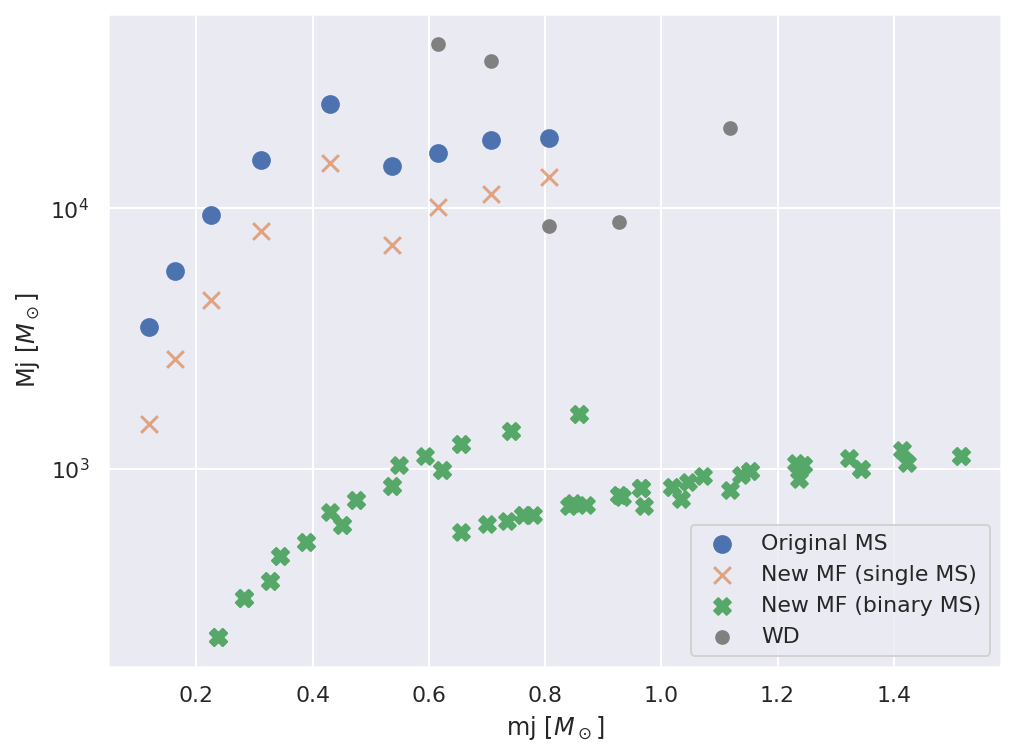

In [13]:
plt.figure()
plt.scatter(mj[bs.MS_mask], Mj[bs.MS_mask], label="Original MS", s=70)

# plt.scatter(mj, Mj, label="Original MF", s=70)

plt.yscale("log")
# plt.ylim(1e2, 1e5)
plt.scatter(
    mj_new[bs.MS_mask_new],
    Mj_new[bs.MS_mask_new],
    label="New MF (single MS)",
    marker="x",
    s=70,
    alpha=0.7,
)
plt.scatter(
    mj_new[bs.bin_mask],
    Mj_new[bs.bin_mask],
    label="New MF (binary MS)",
    marker="X",
    s=70,
)
plt.scatter(
    mj_new[bs.WD_mask_new],
    Mj_new[bs.WD_mask_new],
    label="WD",
    marker="o",
    color="grey",
    s=40,
)

plt.legend()
plt.ylabel(r"Mj [$M_\odot$]")
plt.xlabel(r"mj [$M_\odot$]")
# plt.savefig("shifted.png",dpi=300)
# plt.xlim(0, 1.7)

In [14]:
mj

array([0.11851084, 0.16351292, 0.22560363, 0.31127202, 0.42947124,
       0.53616312, 0.6158897 , 0.70747148, 0.80754321, 0.6158897 ,
       0.70747148, 0.80754321, 0.92779583, 1.11896564, 1.40869427,
       2.81071458, 3.53848001, 4.45468241, 5.60811288, 7.06019582,
       8.88825993])

In [15]:
# Mass ratio
np.sum(Mj_new[bs.bin_mask]) / np.sum(Mj_new[bs.MS_mask_new])

0.7269583944275715

In [16]:
# check mass conservation
print(f"{np.sum(Mj) = :.3f}, {np.sum(Mj_new) = :.3f}")

np.sum(Mj) = 247566.655, np.sum(Mj_new) = 247566.655


In [17]:
# Have a look at Nj

In [18]:
Nj = Mj_new / mj_new

In [19]:
Nj[bs.bin_mask]

array([ 876.39538314,  855.03432581,  834.1939368 ,  741.39777192,
       1893.39520602,  876.39538314,  855.03432581,  834.1939368 ,
        741.39777192, 1595.40375978, 1893.39520602,  876.39538314,
        855.03432581,  834.1939368 ,  741.39777192, 1344.3117261 ,
       1595.40375978, 1893.39520602,  876.39538314,  855.03432581,
        834.1939368 ,  741.39777192, 1132.73780344, 1344.3117261 ,
       1595.40375978, 1893.39520602,  876.39538314,  855.03432581,
        834.1939368 ,  741.39777192, 1132.73780344, 1344.3117261 ,
       1595.40375978, 1893.39520602,  876.39538314,  855.03432581,
        834.1939368 ,  741.39777192,  954.4624116 , 1132.73780344,
       1344.3117261 , 1595.40375978, 1893.39520602,  876.39538314,
        855.03432581,  834.1939368 ,  741.39777192,  954.4624116 ,
       1132.73780344, 1344.3117261 , 1595.40375978, 1893.39520602,
        876.39538314,  855.03432581,  834.1939368 ,  741.39777192,
        954.4624116 , 1132.73780344, 1344.3117261 , 1595.40375

In [20]:
Nj[bs.MS_mask_new]

array([12554.49475284, 16105.8596871 , 19758.15496795, 26315.84262282,
       34701.48714253, 13543.05097688, 16380.12913332, 16035.27712894,
       16310.75098215])

In [21]:
# This is the bad (old) definition
np.sum(Nj[bs.bin_mask]) / np.sum(Nj[bs.MS_mask_new])

0.42323233030693724

In [22]:
# This is the definition we want to use
print(
    f"Binary Fraction: {np.sum(Nj[bs.bin_mask]) / (np.sum(Nj[bs.bin_mask]) + np.sum(Nj[bs.MS_mask_new])) *100:.3f}%"
)

Binary Fraction: 29.737%


## Summary
So it looks like in the old implentation, we were getting $$ f_b = \frac{N_{single}}{N_{bin}}$$ where we actually wanted $$ f_b = \frac{N_{bin}}{N_{bin} + N_{single}} $$ 

Here's the conversion:

If we call the old value of $f_b$ we were inputting $R$ then 

$$
f_b = \frac{R}{1+R}
$$

In [23]:
# Have a look at models

In [24]:
l = limepy(
    M=1e6, phi0=6, g=0.8, mj=mj, Mj=Mj, delta=0.45, rh=8, ra=10 ** 1.23, project=True
)

In [25]:
l_bin = limepy(
    M=1e6,
    phi0=6,
    g=0.8,
    mj=mj_new,
    Mj=Mj_new,
    delta=0.45,
    rh=8,
    ra=10 ** 1.23,
    project=True,
)

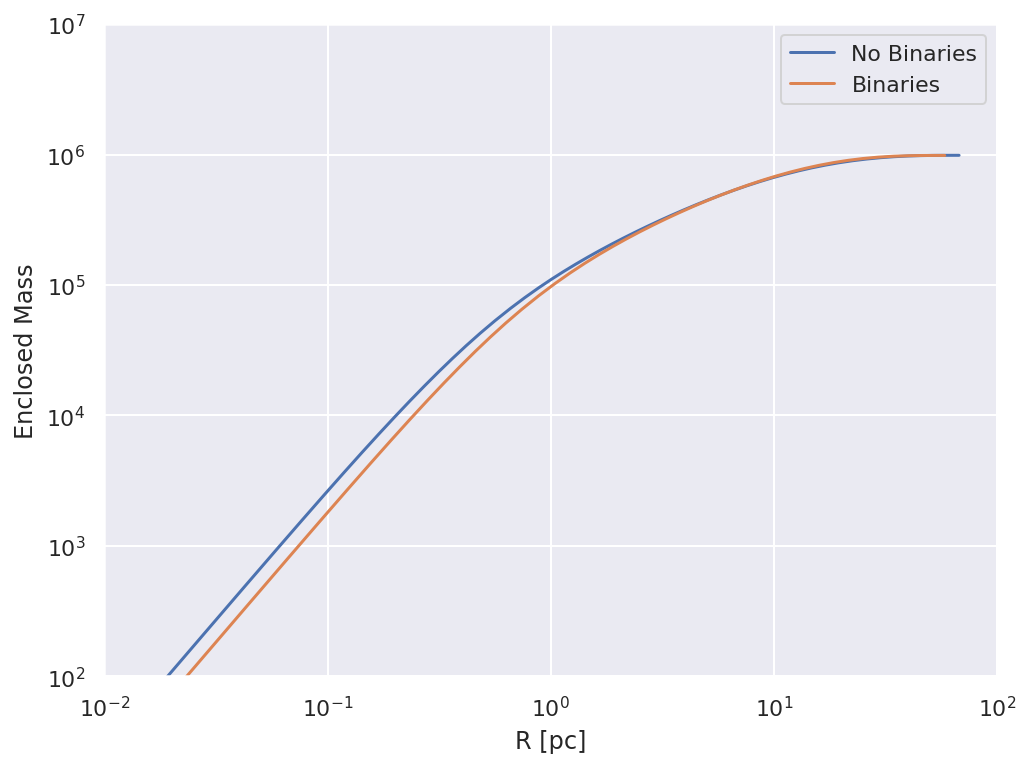

In [26]:
plt.figure()
plt.loglog()
plt.xlim(1e-2, 1e2)
plt.ylim(1e2, 1e7)
plt.plot(l.r, l.mcp, label="No Binaries")
plt.xlabel("R [pc]")
plt.ylabel("Enclosed Mass")
plt.plot(l_bin.r, l_bin.mcp, label="Binaries")
plt.legend()

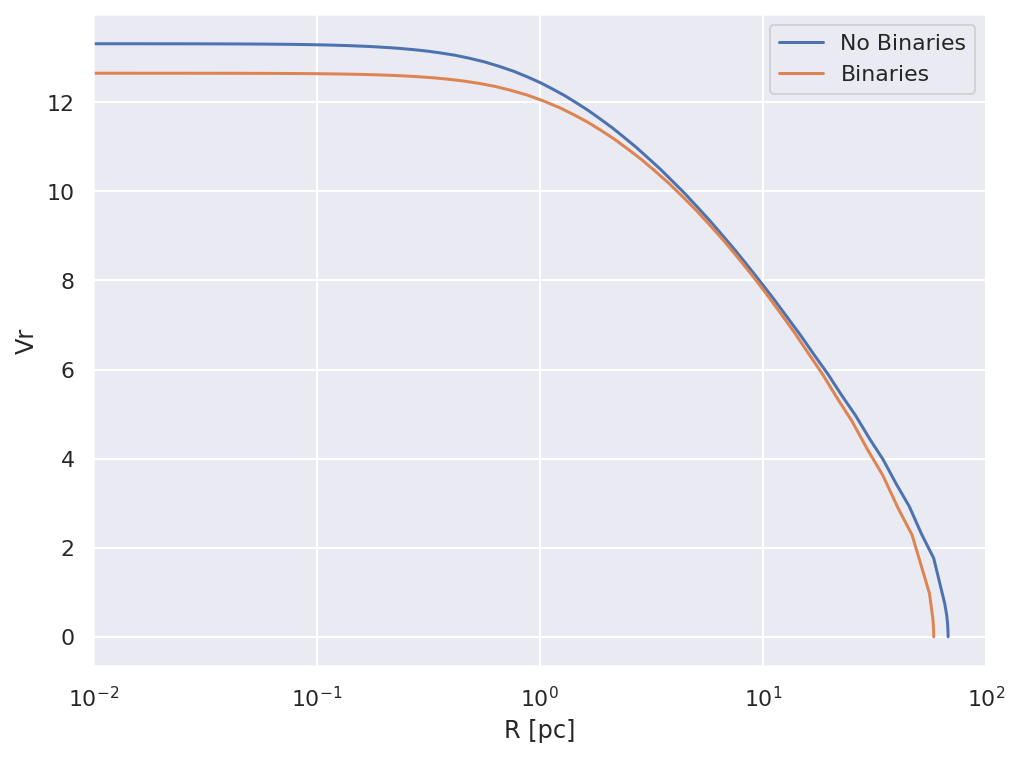

In [27]:
plt.figure()
plt.xscale("log")
plt.xlim(1e-2, 1e2)
plt.plot(l.r, np.sqrt(l.v2R), label="No Binaries")
plt.xlabel("R [pc]")
plt.ylabel("Vr")
plt.plot(l_bin.r, np.sqrt(l_bin.v2R), label="Binaries")
plt.legend()

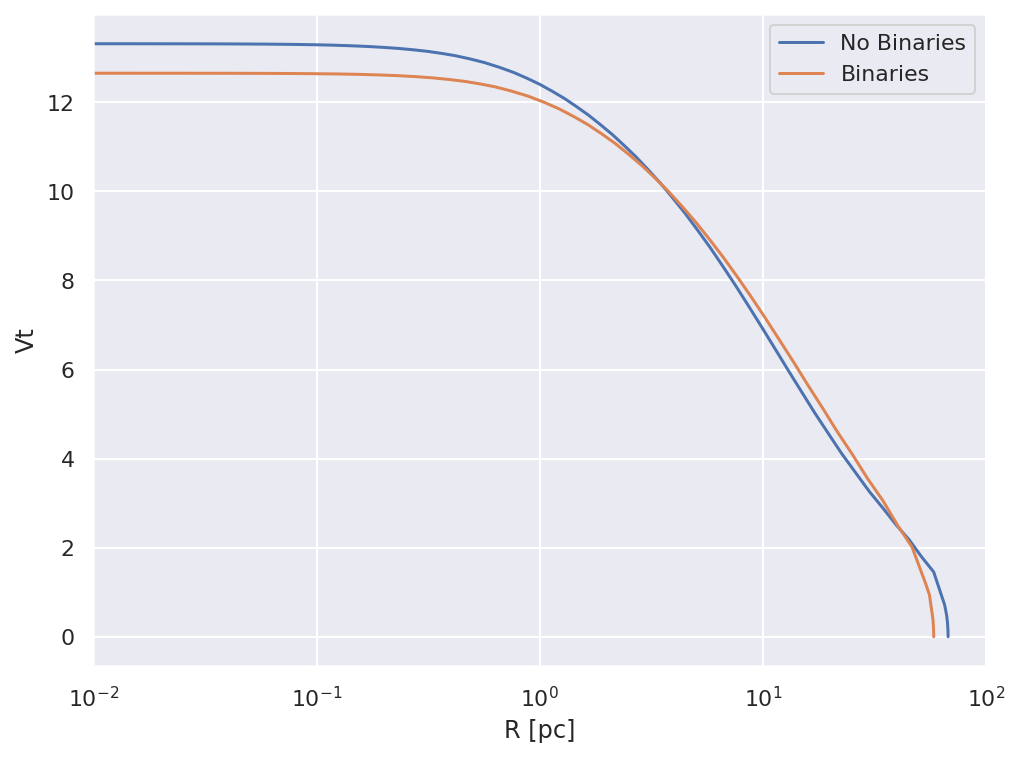

In [28]:
plt.figure()
plt.xscale("log")
plt.xlim(1e-2, 1e2)
plt.plot(l.r, np.sqrt(l.v2T), label="No Binaries")
plt.xlabel("R [pc]")
plt.ylabel("Vt")
plt.plot(l_bin.r, np.sqrt(l_bin.v2T), label="Binaries")
plt.legend()

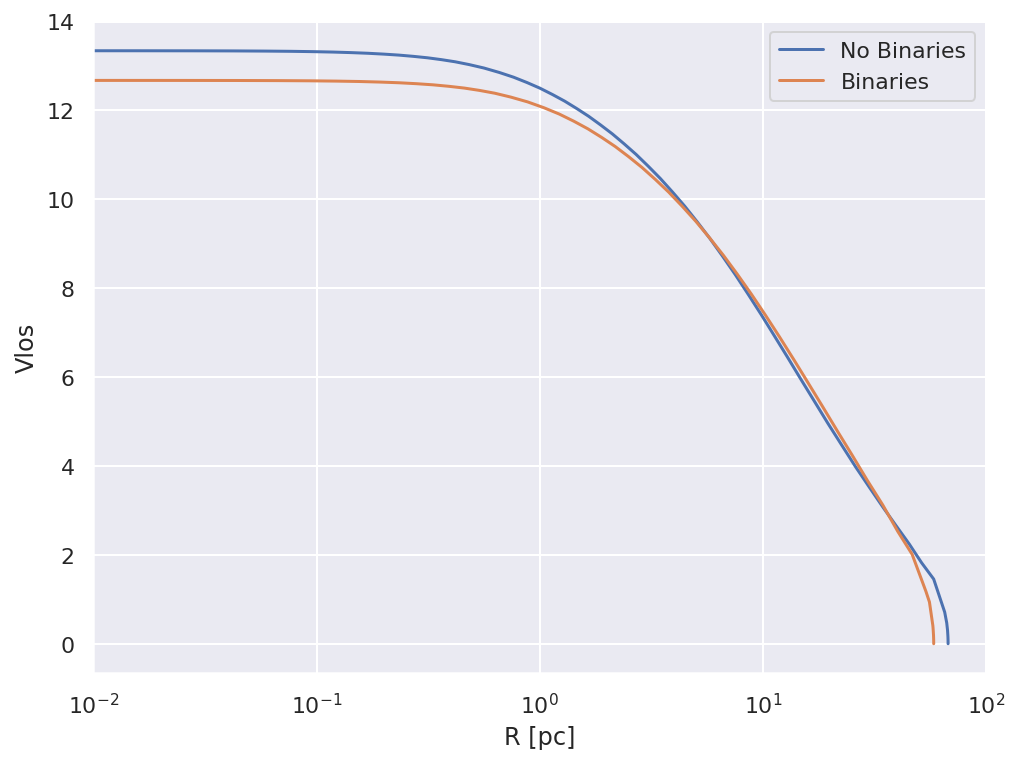

In [29]:
plt.figure()
plt.xscale("log")
plt.xlim(1e-2, 1e2)
plt.plot(l.r, np.sqrt(l.v2p), label="No Binaries")
plt.xlabel("R [pc]")
plt.ylabel("Vlos")
plt.plot(l_bin.r, np.sqrt(l_bin.v2p), label="Binaries")
plt.legend()

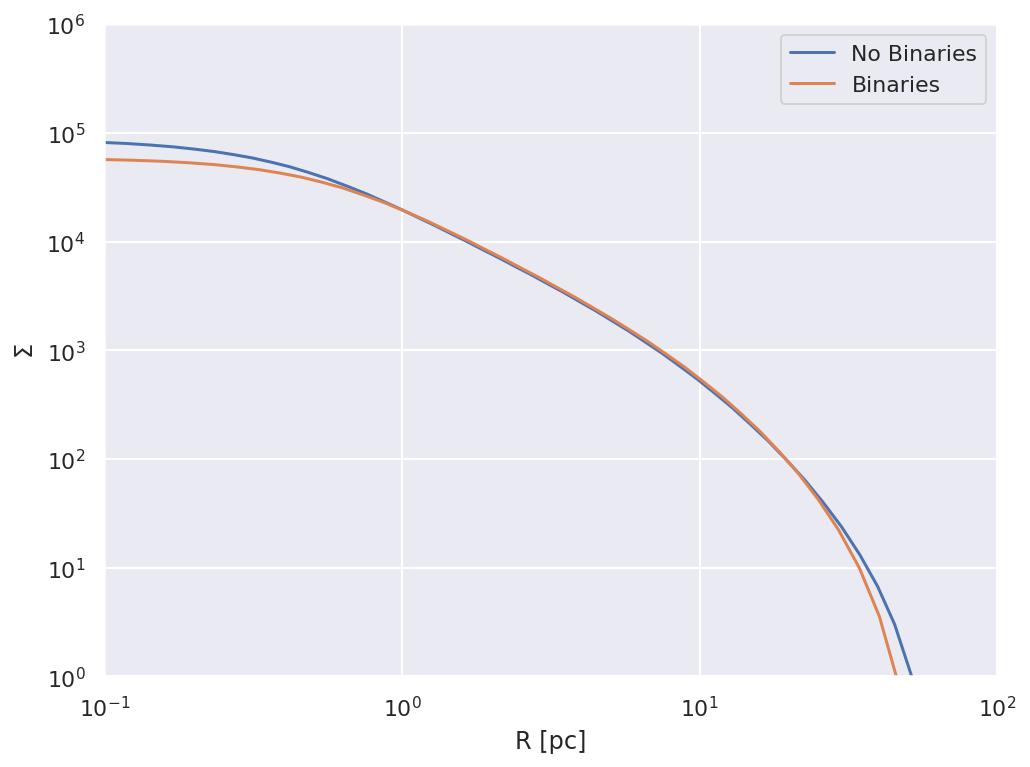

In [30]:
plt.figure()
plt.loglog()
plt.xlim(1e-1, 1e2)
plt.ylim(1e-0, 1e6)
plt.plot(l.r, l.Sigma, label="No Binaries")
plt.xlabel("R [pc]")
plt.ylabel(r"$\Sigma$")
plt.plot(l_bin.r, l_bin.Sigma, label="Binaries")
plt.legend()